Universidad del Valle de Guatemala - UVG<br />
Facultad de Computación<br />
Visión por Computadora<br />
Autores:<br />
 - Diego Alexander Hernández Silvestre - 21270<br />
 - Linda Inés Jiménez Vides - 21169<br />
 - José Andrés Auyón Cobar - 201579 

In [25]:
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np
import os

### Problema 1

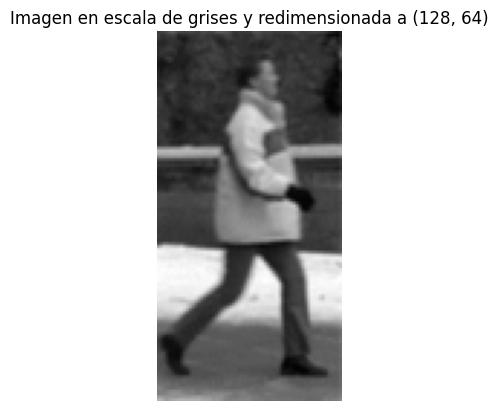

Shape final: (128, 64)


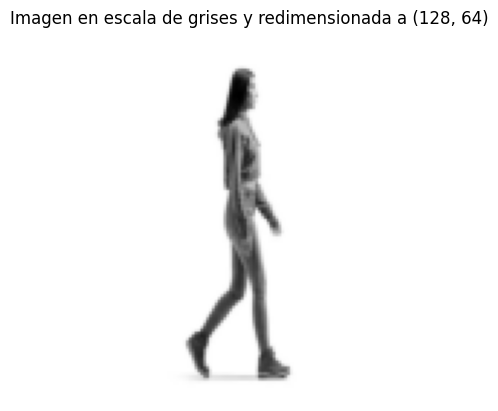

Shape final: (128, 64)


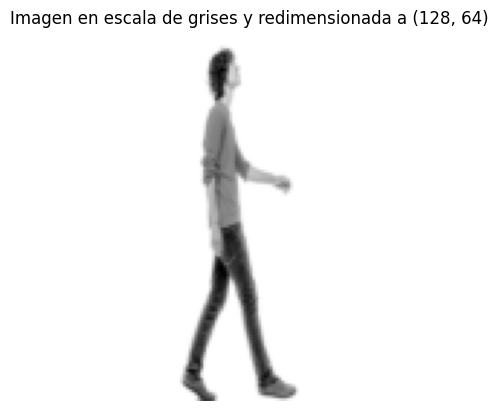

Shape final: (128, 64)


In [26]:
k = 1

def inciso1(imagePath):
    I = plt.imread(imagePath)
    Igray = ski.color.rgb2gray(I[:,:,:3])
    plt.imshow(I, cmap='gray')
    newShape = (128 * k, 64 * k)
    Ishaped = ski.transform.resize(Igray, newShape, anti_aliasing=True)
    plt.imshow(Ishaped, cmap='gray')
    plt.title(f"Imagen en escala de grises y redimensionada a {newShape}")
    plt.axis('off')
    plt.show()
    print("Shape final:", Ishaped.shape)
    return Ishaped

folder = "data/"
files = os.listdir(folder)
arrayImages = []
for file in files:
    imagePath = folder + file
    arrayImages.append(inciso1(imagePath))

### Problema 2

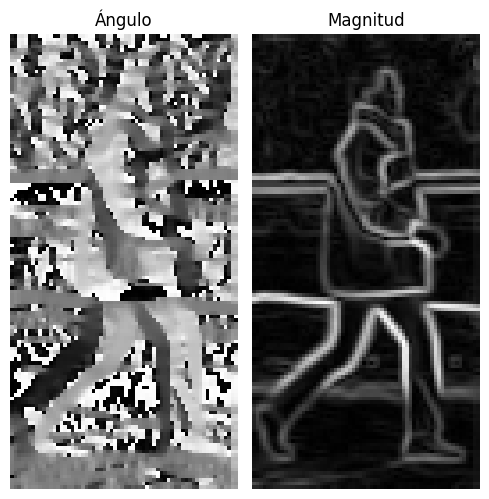

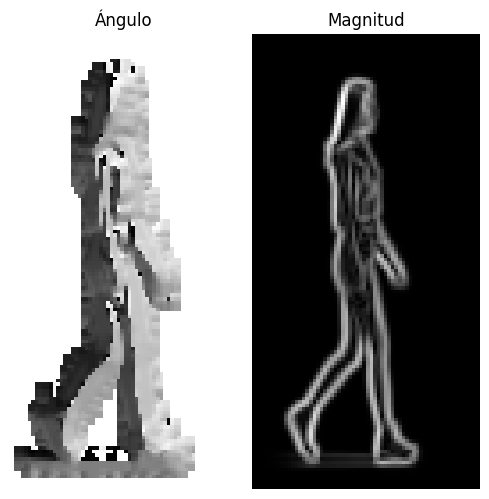

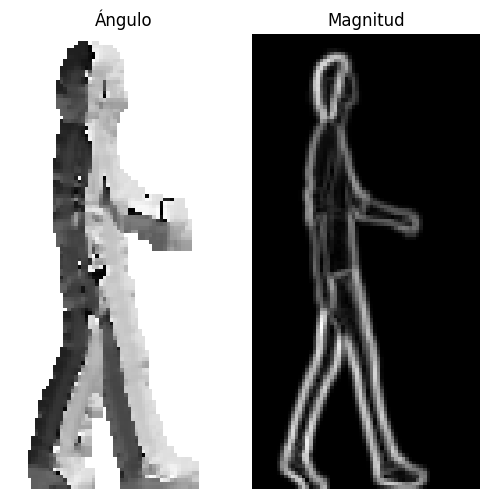

In [27]:

def calculateAngleAndMagnitude(I):
    Ix = ski.filters.prewitt_h(I)
    Iy = ski.filters.prewitt_v(I)
    angle = ski.img_as_float(180 + (180 / 3.14159265358979323846) * np.arctan2(Iy, Ix))
    magnitude = ski.img_as_float(np.sqrt(Ix**2 + Iy**2))
    return angle, magnitude

for i in arrayImages:
    angle, magnitude = calculateAngleAndMagnitude(i)
    plt.figure(figsize=(5, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(angle, cmap='gray')
    plt.title("Ángulo")
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(magnitude, cmap='gray')
    plt.title("Magnitud")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


### Problema 3

In [28]:
def constructBlocksStack(magnitude, angle, blockSize, recommendedStride=False):
    if recommendedStride: 
        stride = blockSize
    else:
        stride = blockSize // 2
    height, width = magnitude.shape
    M = (height - blockSize) // stride + 1
    N = (width - blockSize) // stride + 1
    stackMagnitude = np.zeros((M, N, blockSize, blockSize))
    stackAngle = np.zeros((M, N, blockSize, blockSize))
    for mi, i in enumerate(range(0, height - blockSize + 1, stride)):
        for nj, j in enumerate(range(0, width - blockSize + 1, stride)):
            stackMagnitude[mi, nj] = magnitude[i:i + blockSize, j:j + blockSize]
            stackAngle[mi, nj] = angle[i:i + blockSize, j:j + blockSize]
    return stackMagnitude, stackAngle


blockSize = 4

for i in arrayImages:
    angle, magnitude = calculateAngleAndMagnitude(i)
    stackMagnitude, stackAngle = constructBlocksStack(magnitude, angle, blockSize)
    print("Stack magnitud shape:", stackMagnitude.shape)
    print("Stack ángulo shape:", stackAngle.shape)

Stack magnitud shape: (63, 31, 4, 4)
Stack ángulo shape: (63, 31, 4, 4)
Stack magnitud shape: (63, 31, 4, 4)
Stack ángulo shape: (63, 31, 4, 4)
Stack magnitud shape: (63, 31, 4, 4)
Stack ángulo shape: (63, 31, 4, 4)


### Problema 4

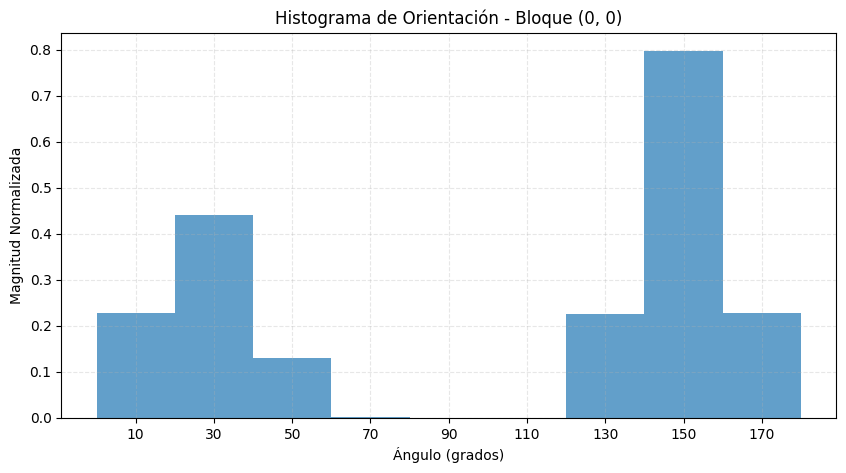

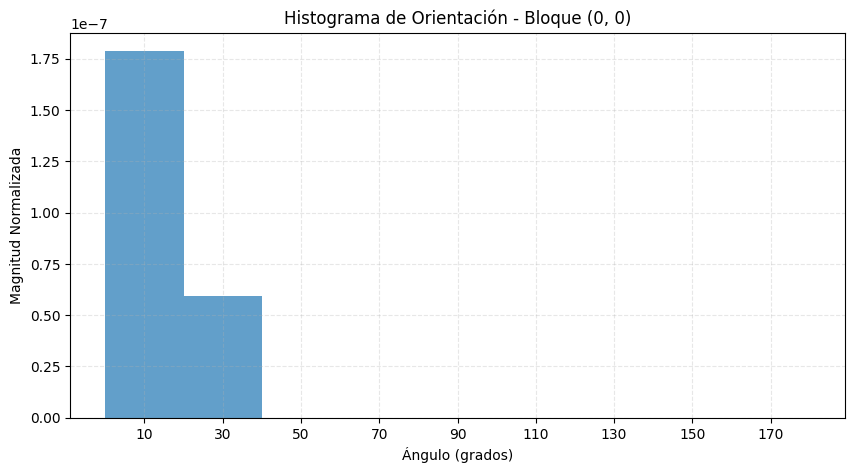

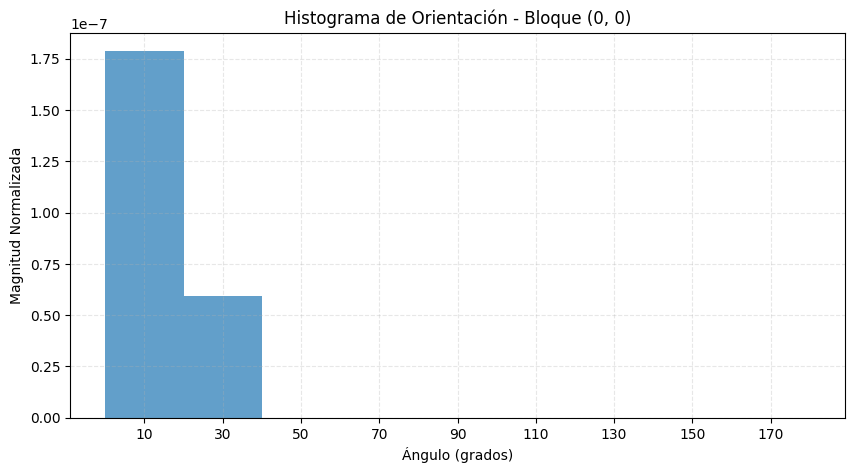

In [29]:
def constructHistogram(stackMagnitude, stackAngle, numBins):
    M, N, h, w = stackMagnitude.shape
    H = np.zeros((M, N, numBins))
    binWidth = 180 / numBins
    binCenters = np.linspace(binWidth / 2, 180 - binWidth / 2, numBins)
    eps = np.finfo(float).eps
    for m in range(M):
        for n in range(N):
            magBlock = stackMagnitude[m, n]
            angleBlock = stackAngle[m, n]
            histogram = np.zeros(numBins)
            for i in range(h):
                for j in range(w):
                    angle = angleBlock[i, j] % 180
                    mag = magBlock[i, j]
                    binIndex = angle / binWidth
                    b1 = int(np.floor(binIndex)) % numBins
                    b2 = (b1 + 1) % numBins
                    c1 = binCenters[b1]
                    c2 = binCenters[b2]
                    w1 = abs(c2 - angle) / binWidth
                    w2 = abs(angle - c1) / binWidth
                    histogram[b1] += mag * w1
                    histogram[b2] += mag * w2
            norm = np.sqrt(np.sum(histogram**2) + eps)
            H[m, n] = histogram / norm
    return H, binCenters

def graphHistogram(histogram, binCenters, m=0, n=0):
    hist = histogram[m, n]
    plt.figure(figsize=(10, 5))
    plt.bar(binCenters, hist, width=binCenters[1] - binCenters[0], align='center', alpha=0.7)
    plt.xticks(binCenters)
    plt.title(f"Histograma de Orientación - Bloque ({m}, {n})")
    plt.xlabel("Ángulo (grados)")
    plt.ylabel("Magnitud Normalizada")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

blockSize = 4
numBins = 9
for i in arrayImages:
    angle, magnitude = calculateAngleAndMagnitude(i)
    stackMagnitude, stackAngle = constructBlocksStack(magnitude, angle, blockSize)
    histogram, binCenters = constructHistogram(stackMagnitude, stackAngle, numBins)
    graphHistogram(histogram, binCenters)

### Problema 5

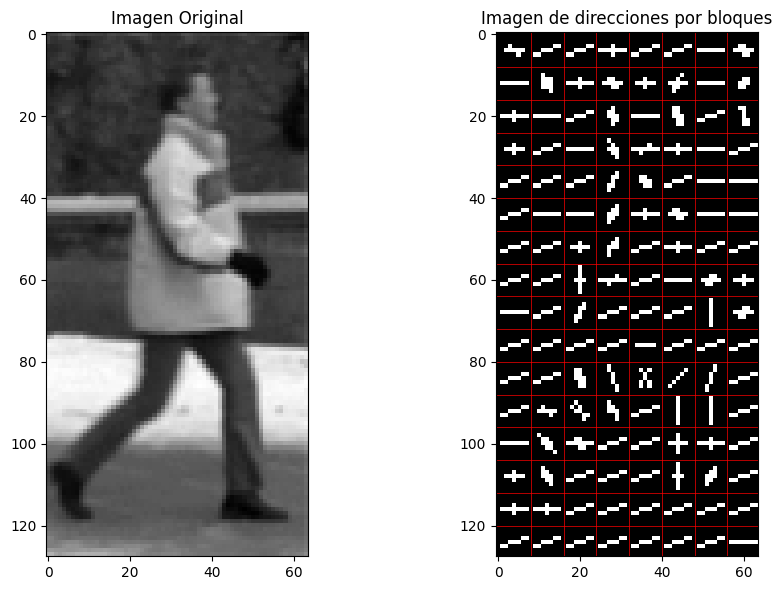

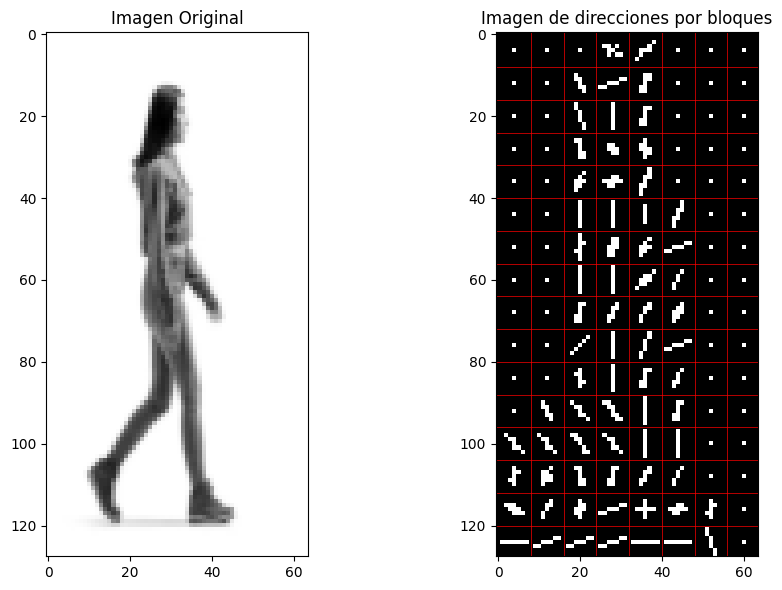

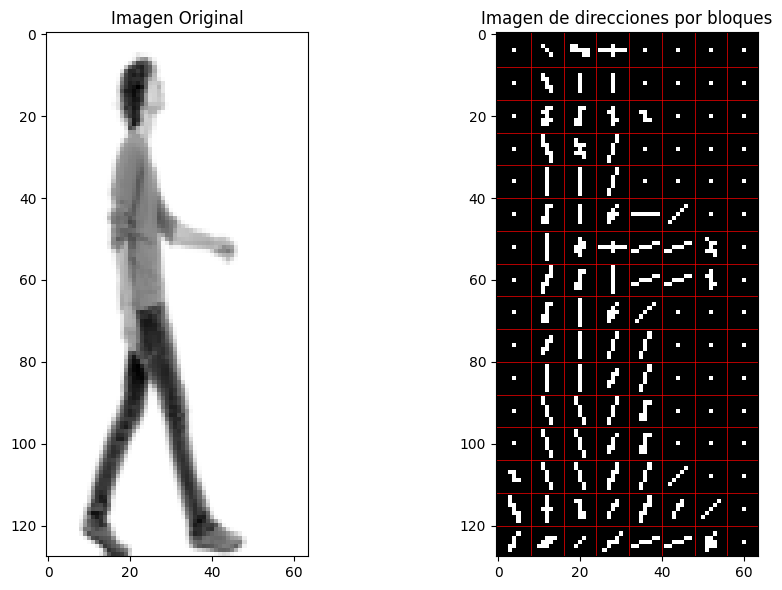

In [30]:
def visualizeHistogramBlocks(H, binCenters, blockSize):
    M, N, numBins = H.shape
    height = M * blockSize
    width = N * blockSize

    visualImage = np.zeros((height, width), dtype=np.float32)

    for m in range(M):
        for n in range(N):
            hist = H[m, n]

            center_y = m * blockSize + blockSize // 2
            center_x = n * blockSize + blockSize // 2

            for b in range(numBins):
                angle_deg = binCenters[b]
                angle_rad = np.deg2rad(angle_deg)
                magnitude = hist[b]

                length = (blockSize // 2 - 1) * magnitude

                dx = int(round(length * np.cos(angle_rad)))
                dy = int(round(length * np.sin(angle_rad)))

                x1 = center_x - dx
                y1 = center_y - dy
                x2 = center_x + dx
                y2 = center_y + dy

                rr, cc = ski.draw.line(y1, x1, y2, x2)
                rr = np.clip(rr, 0, height - 1)
                cc = np.clip(cc, 0, width - 1)

                visualImage[rr, cc] += 1.0 

    visualImage = np.clip(visualImage, 0, 1)
    return visualImage

def plotVisualComparison(originalGray, visual, blockSize):
    M = visual.shape[0] // blockSize
    N = visual.shape[1] // blockSize
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(originalGray, cmap='gray')
    plt.title("Imagen Original")
    plt.axis('on')
    plt.subplot(1, 2, 2)
    plt.imshow(visual, cmap='gray')
    plt.title("Imagen de direcciones por bloques")
    for m in range(1, M):
        y = m * blockSize
        plt.axhline(y, color='red', linewidth=0.5)
    for n in range(1, N):
        x = n * blockSize
        plt.axvline(x, color='red', linewidth=0.5)
    plt.axis('on')
    plt.tight_layout()
    plt.show()

blockSize = 8
numBins = 9

for file in arrayImages:
    angle, magnitude = calculateAngleAndMagnitude(file)
    stackMagnitude, stackAngle = constructBlocksStack(magnitude, angle, blockSize, recommendedStride=True)
    histogram, binCenters = constructHistogram(stackMagnitude, stackAngle, numBins)
    visual = visualizeHistogramBlocks(histogram, binCenters, blockSize)
    Igray = ski.transform.resize(file, visual.shape, anti_aliasing=True)
    plotVisualComparison(Igray, visual, blockSize)


### Problema 6

### Problema 7